<a href="https://colab.research.google.com/github/yifeiz-bu/Industrial-project/blob/main/YMT_product_label_classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [ ]:
#Make the necessary imports
import os
import sys
import tarfile
import warnings
warnings.filterwarnings("ignore")
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
import pandas as pd
import numpy as np
!pip install gensim
!pip install python-Levenshtein
import multiprocessing
from gensim.models import Word2Vec
!pip install jieba
import jieba
import string
!pip install wget==3.2
!pip install tensorflow
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3852b3294cd3303658d804444e1b5c47169eed9934845ff13f36a1ec0ad97888
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your model file on Google Drive
pretrained_model = '/content/drive/MyDrive/model_file'

In [ ]:
#Load pre trained model
w2v_model = '/content/sgns.weibo.bigram-char'

In [ ]:
w2v_model2 = '/content/drive/My Drive/sgns.merge.bigram'

# data feature engineering and cleaning

load the dataset

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/8031.csv',sep='\t',names=['IN code','pk','description'])
df2 = pd.read_csv('/content/drive/My Drive/8453.csv',sep='\t',names=['IN code','pk','description'])
df3 = pd.read_csv('/content/drive/My Drive/8199.csv',sep='\t',names=['IN code','pk','description'])

In [ ]:
del df1['pk'],df2['pk'],df3['pk']
#concatation
df = pd.concat([df1, df2,df3],ignore_index = True,sort = False)
df_ori = df[(df['IN code']== 8031) | (df['IN code']== 8453) |(df['IN code']== 8199)].reset_index()

In [ ]:
df_ori['description'] #inspect the original dataset

,description
0,精品黄金梨又甜又脆，口感非常的好，货好的很
1,酥梨 600g以上 膜袋
2,河北皇冠梨赵县梨新鲜梨子 品质好 价格优 欢迎来聊
3,万亩梨园有机富硒梨长十郎 皇冠梨，黄金梨
4,苏翠一号梨大量上市口感好糖度高
...,...
13963,冰糖心苹果红富士苹果有机苹果水果批发脆甜可口绿色食品
13964,红星苹果 80mm以上 膜袋 甜 糖心 红 批发
13965,铜川嘎啦苹果，口感甜脆，健康又美味。
13966,山东烟台栖霞红富士苹果即将大量上市


In [ ]:
df = df_ori.copy() #duplicate the experimental dataset

Remove punctuation and white space

In [ ]:
string.punctuation + '。'+'，'+'！'+'？'+'、'+'；' +'（'+'）'+'【'+'】'+'《'+'》'+'…'+'—'+'‘'+'’'+'“'+'”'+'‘'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~。，！？、；（）【】《》…—‘’“”‘'

In [ ]:
punct_combined = string.punctuation + '。'+'，'+'！'+'？'+'、'+'；' +'（'+'）'+'【'+'】'+'《'+'》'+'…'+'—'+'‘'+'’'+'“'+'”'+'‘'
punct_combined

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~。，！？、；（）【】《》…—‘’“”‘'

In [ ]:
# a list to store non-punctuation words
non_punct = []

# loops through each sentence in the `title` column and then checks each word in the text
# keeps it in the letters list if non-punctuation
for word in df['description']:
    letters = [letter for letter in word if letter not in punct_combined and not letter.isdigit()]
    non_punct.append(''.join(letters))

df['description'] = pd.Series(non_punct)
df.head()

,index,IN code,description
0,0,8031,精品黄金梨又甜又脆口感非常的好货好的很
1,1,8031,酥梨 g以上 膜袋
2,3,8031,河北皇冠梨赵县梨新鲜梨子 品质好 价格优 欢迎来聊
3,4,8031,万亩梨园有机富硒梨长十郎 皇冠梨黄金梨
4,5,8031,苏翠一号梨大量上市口感好糖度高


Remove stopwords

In [ ]:
#nltk.download('stopwords')
#stopword = nltk.corpus.stopwords.words('chinese')
## pring the first 11 stop words in the list
#print(stopword[:11])

In [ ]:
## a list to store stopwords
#stopwords = []
#
## loops through each sentence in the `title_non_punct_split` column and then
## stores words in a list of non_stop if the word is not a stopword
## then finally appends each list into stopwords
#for zi in df['description']:
#    non_stop = [word for word in zi if word not in stopword]
#    stopwords.append(non_stop)
#
#df['description'] = pd.Series(stopwords)
#df.head()

#Tokenize

In [ ]:
token_lis = []
for i in df['description']:
  # Join the list of words back into a string
  text = ''.join(i)
  seg_list = list(jieba.lcut(text)) # 搜索引擎模式
  x = (','.join(seg_list))
  token_lis.append(seg_list)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.596 seconds.
DEBUG:jieba:Loading model cost 0.596 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
df['description_token']=token_lis
df

,index,IN code,description,description_token
0,0,8031,精品黄金梨又甜又脆口感非常的好货好的很,"[精品, 黄金梨, 又, 甜, 又, 脆, 口感, 非常, 的, 好, 货好, 的, 很]"
1,1,8031,酥梨 g以上 膜袋,"[酥梨, , g, 以上, , 膜袋]"
2,3,8031,河北皇冠梨赵县梨新鲜梨子 品质好 价格优 欢迎来聊,"[河北, 皇冠, 梨, 赵县, 梨, 新鲜, 梨子, , 品质, 好, , 价格, 优,..."
3,4,8031,万亩梨园有机富硒梨长十郎 皇冠梨黄金梨,"[万亩, 梨园, 有机, 富, 硒, 梨, 长十郎, , 皇冠, 梨, 黄金梨]"
4,5,8031,苏翠一号梨大量上市口感好糖度高,"[苏翠, 一号, 梨, 大量, 上市, 口感, 好, 糖度, 高]"
...,...,...,...,...
13963,14995,8199,冰糖心苹果红富士苹果有机苹果水果批发脆甜可口绿色食品,"[冰糖, 心, 苹果, 红富士, 苹果, 有机, 苹果, 水果, 批发, 脆甜, 可口, 绿..."
13964,14996,8199,红星苹果 mm以上 膜袋 甜 糖心 红 批发,"[红星, 苹果, , mm, 以上, , 膜袋, , , 甜, , 糖心, , ..."
13965,14997,8199,铜川嘎啦苹果口感甜脆健康又美味,"[铜川, 嘎啦, 苹果, 口感, 甜脆, 健康, 又, 美味]"
13966,14998,8199,山东烟台栖霞红富士苹果即将大量上市,"[山东, 烟台, 栖霞, 红富士, 苹果, 即将, 大量, 上市]"


Create test,training sets

In [ ]:
df['IN code'] = df_ori['IN code']

In [ ]:
df['IN code'].value_counts()

,count
IN code,
8031,4785
8199,4762
8453,4421


In [ ]:
# Encoding the label column
y = df['IN code'].astype(str).map({'8031': 1, '8453': 2,'8199':3})

X_train, X_val, y_train, y_val = train_test_split(df['description_token'], y, test_size=0.2, random_state=42)

In [ ]:
y_train

,IN code
4112,1
4850,2
12997,3
3016,1
12656,3
...,...
5191,2
13418,3
5390,2
860,1


### Apply Gensim Word2Vec model to train the word vectors based on the training data as the corpus.

In [ ]:
from gensim.models import Word2Vec
import warnings
from collections import defaultdict  # Import defaultdict

In [ ]:
sentences = df['description_token']  # No need to call .split() since the data is already tokenized
word_freq = defaultdict(int)

# Loop through each token in each sentence (list of tokens)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

# Sort and retrieve the 10 most frequent words
top_10_words = sorted(word_freq, key=word_freq.get, reverse=True)[:10]
top_10_words


[' ', '苹果', '香蕉', '梨', '红富士', '大量', '的', '产地', '上市', '酥梨']

In [ ]:
# Create CBOW model
warnings.filterwarnings('ignore')# define training data
w2v_model = Word2Vec(df['description_token'], min_count=1,
                                vector_size=300, window=5)


In [ ]:
#Represent first 50 of the words that our Word2Vec model learned a vector for.
w2v_model.wv.index_to_key[:50]

[' ',
 '苹果',
 '香蕉',
 '梨',
 '红富士',
 '大量',
 '的',
 '产地',
 '上市',
 '酥梨',
 '蕉',
 '精品',
 '口感',
 '好',
 '欢迎',
 '大',
 '云南',
 '有',
 '一件',
 '代发',
 '皇冠',
 '批发',
 '供应',
 '红',
 '广西',
 '水果',
 '联系',
 '新鲜',
 '了',
 '陕西',
 '直销',
 '富士',
 '货',
 '纸袋',
 '以上',
 '需要',
 '甜',
 '脆甜',
 '货源',
 '基地',
 '价格',
 '冰糖',
 '斤',
 '山东',
 '进口',
 '优质',
 'g',
 '老板',
 '不',
 '小米']

In [ ]:
# Find the most similar words to "king" based on word vectors from our trained model
w2v_model.wv.most_similar('鸭梨')

[('梨', 0.9954535961151123),
 ('丰水', 0.9953941106796265),
 ('雪花', 0.9953888058662415),
 ('水晶', 0.9928445816040039),
 ('皇冠', 0.9917600154876709),
 ('赵县', 0.9893616437911987),
 ('秋月', 0.9893259406089783),
 ('锦丰', 0.9868800640106201),
 ('河北', 0.9868581891059875),
 ('两', 0.9863934516906738)]

In [ ]:
words = set(w2v_model.wv.index_to_key )

In [ ]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = [np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train]
X_test_vect = [np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val]

In [ ]:
# Calculate the maximum number of words in any sentence to ensure consistent array shape
max_length = max(len(ls) for ls in X_train)

def pad_vectors(sentences, words, max_length):
    padded_vectors = []
    for sentence in sentences:
        sentence_vectors = [w2v_model.wv[word] for word in sentence if word in words]
        # Pad with zero vectors if sentence is shorter than max_length
        if len(sentence_vectors) < max_length:
            sentence_vectors += [np.zeros(w2v_model.vector_size)] * (max_length - len(sentence_vectors))
        padded_vectors.append(sentence_vectors)
    return np.array(padded_vectors)

X_train_vect = pad_vectors(X_train, words, max_length)
X_test_vect = pad_vectors(X_val, words, max_length)

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

# ML configuration

In [ ]:
from sklearn.linear_model import LinearRegression,LogisticRegressionCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from keras import models,layers,optimizers,losses,metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Logistic regression

In [ ]:
#Instantiate
model = LogisticRegressionCV(class_weight='balanced')

#Fit
model.fit(X_train_vect_avg, y_train)

#Predict
predictions = model.predict(X_test_vect_avg)

#Assess
standard_accuracy = accuracy_score(predictions,y_val)

In [ ]:
print(standard_accuracy)

0.9538296349319971


In [ ]:
print(classification_report(y_val,predictions,labels=y.unique()))

              precision    recall  f1-score   support

           1       0.92      0.97      0.94       975
           3       0.97      0.93      0.95       955
           2       0.98      0.96      0.97       864

    accuracy                           0.95      2794
   macro avg       0.96      0.95      0.95      2794
weighted avg       0.95      0.95      0.95      2794



save the model into local memory

In [ ]:
model.save('/content/drive/My Drive/.model')

AttributeError: 'LogisticRegressionCV' object has no attribute 'save'

Multi-lablel classification with logistic regression

In [ ]:
clf = LogisticRegressionCV(cv=5,penalty= 'elasticnet', solver= 'saga', l1_ratios=[0.1,0.5], random_state=90393).fit(X_train_vect_avg, y_train)
y_pred= clf.predict(X_test_vect_avg)

In [ ]:
print(classification_report(y_test,y_pred,labels=df['IN code'].unique()))

#SVM

In [ ]:
from sklearn.svm import SVC,LinearSVC
import sklearn.model_selection as model_selection

In [ ]:
# Build model and test for prediction
svm = LinearSVC()
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train_vect_avg, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_train_vect_avg, y_train)
poly_pred = poly.predict(X_test_vect_avg)
rbf_pred = rbf.predict(X_test_vect_avg)

In [ ]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

In [ ]:
print(classification_report(y_test,poly_pred,labels=df['IN code'].unique()))

In [ ]:
print(classification_report(y_test,rbf_pred,labels=df['IN code'].unique()))

# Random Forest ensemble tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

New version

In [ ]:
# Instantiate and fit a basic Random Forest model on top of the vectors
rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [ ]:
from sklearn.metrics import precision_score, recall_score
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('f1: {} / Accuracy: {}'.format(
    round(f1_score,10), round((y_pred==y_test).sum()/len(y_pred), 3)))

old version

In [ ]:
model = RandomForestClassifier(n_estimators=10000, # num of trees
                               random_state=42) #randomness control
#Fit
model.fit(X_train_vect_avg, y_train)

#Predict
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

#Assess
standard_accuracy_test = accuracy_score(test_predictions,y_test)
standard_accuracy_train = accuracy_score(train_predictions,y_train)
print(standard_accuracy_test)
print(standard_accuracy_train)

In [ ]:
print(metrics.classification_report(y_test, predictions))

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Logistic Regression with pre-trained embeddings

Per inspection, we found that self-trained word embedding yields pretty good result. Hwoever, we msut take cosnideration of the overfitting under the context given that our corpus is relatively small (1000 sentences). Therefore, we shoudl also try different methods of using pre-trained vectors of chinese dictionary/

In [ ]:
# Load and preprocess the corpus
with open('/content/sgns.weibo.bigram-char', 'r', encoding='utf-8') as f:
    corpus = f.readlines()

# Tokenize each sentence in the corpus
corpus_tokenized = [word_tokenize(sentence.lower()) for sentence in corpus]

# Train Word2Vec model
embedding_dim = 100  # You can set the embedding dimension as needed
word2vec_model = Word2Vec(sentences=corpus_tokenized, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Save the model for future use
word2vec_model.save('word2vec.model')

#Represent first 50 of the words that our Word2Vec model learned a vector for.
w2v_model.wv.index_to_key[:50]

In [ ]:
# Find the most similar words to "king" based on word vectors from our trained model
word2vec_model.wv.most_similar('苹果')

In [ ]:
words = set(word2vec_model.wv.index_to_key )
words = set(word2vec_model.wv.index_to_key )
X_train_vect = [np.array([word2vec_model.wv[i] for i in ls if i in words])
                         for ls in X_train]
X_test_vect = [np.array([word2vec_model.wv[i] for i in ls if i in words])
                         for ls in X_val]
# Calculate the maximum number of words in any sentence to ensure consistent array shape
max_length = max(len(ls) for ls in X_train)

def pad_vectors(sentences, words, max_length):
    padded_vectors = []
    for sentence in sentences:
        sentence_vectors = [word2vec_model.wv[word] for word in sentence if word in words]
        # Pad with zero vectors if sentence is shorter than max_length
        if len(sentence_vectors) < max_length:
            sentence_vectors += [np.zeros(word2vec_model.vector_size)] * (max_length - len(sentence_vectors))
        padded_vectors.append(sentence_vectors)
    return np.array(padded_vectors)

X_train_vect = pad_vectors(X_train, words, max_length)
X_test_vect = pad_vectors(X_val, words, max_length)
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
#Instantiate
model = LogisticRegressionCV(class_weight='balanced')

#Fit
model.fit(X_train_vect_avg, y_train)

#Predict
predictions = model.predict(X_test_vect_avg)

#Assess
standard_accuracy = accuracy_score(predictions,y_val)

In [ ]:
print(classification_report(y_val,predictions,labels=y.unique()))

It turns out that the model perofrm poorly absed on the pre-trained word embeddings. Many reasons could induce to such result, namely one of them being the improper use of the corpus for the pre-training. Other reasons,like using the improper ML models, would also inccur this result. But for now let's stay with the self trained embedding vectors.

# Dense layer network

##RNN

In [ ]:
#Make the necessary imports
import tarfile
import wget
import warnings
warnings.filterwarnings("ignore")
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
nltk.download('wordnet')
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


Tokenizing and Padding

### First, start with a baseline model using pre-trained embeddings without parameter tuning

In [ ]:
# Load and preprocess the pre-trained corpus
with open(w2v_model2, 'r', encoding='utf-8') as f:
    corpus = f.readlines()

# Tokenize each sentence in the corpus
corpus_tokenized = [word_tokenize(sentence.lower()) for sentence in corpus]

# Train Word2Vec model
embedding_dim = 300  # You can set the embedding dimension as needed
word2vec_model = Word2Vec(sentences=corpus_tokenized, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Save the model for future use
word2vec_model.save('word2vec.model')

In [ ]:
# Load pre-trained Word2Vec model.
word2vec_model = Word2Vec.load("word2vec.model")

In [ ]:
word2vec_model.wv.most_similar('嘎啦')

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from keras.optimizers import Adam
from keras.regularizers import l2

In [ ]:
# Load the trained Word2Vec model
#word2vec_model = Word2Vec.load('word2vec.model')

embedding_dim = 300
texts = df['description_token'].tolist()

# Tokenize the input sequences (fit a tokenizer)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convert texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences to ensure uniform input size for the LSTM model
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Preparing the embedding matrix from the Word2Vec model
vocab_size = len(word_index) + 1  # Account for padding token

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))  # Handle OOV words

print(f"Embedding matrix shape: {embedding_matrix.shape}")

In [ ]:
# Assume df['IN code'] contains the target categorical labels

# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['IN code'])  # Convert categorical labels to integers

# Step 2: One-hot encode the labels (fix the shape issue)
num_classes = 3  # You already know there are 3 unique categories
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Step 3: Split the data into training and validation sets
# Assuming `X` contains your input features (tokenized and padded sequences)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.2, random_state=42)
# Now define and compile your model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Step 4: Build the LSTM model
model = Sequential()

# Add embedding layer (make sure vocab_size and embedding_matrix are defined)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Add LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Add output layer (number of units must match the number of categories)
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (fit the model)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)


Epoch 1/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3856 - loss: 1.0717 - val_accuracy: 0.4496 - val_loss: 0.9961
Epoch 2/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4930 - loss: 0.9645 - val_accuracy: 0.4726 - val_loss: 0.9593
Epoch 3/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5111 - loss: 0.9189 - val_accuracy: 0.4743 - val_loss: 0.9611
Epoch 4/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5239 - loss: 0.8908 - val_accuracy: 0.5761 - val_loss: 0.9544
Epoch 5/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5435 - loss: 0.8686 - val_accuracy: 0.5084 - val_loss: 0.9461
Epoch 6/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5828 - loss: 0.8277 - val_accuracy: 0.5203 - val_loss: 0.9522
Epoch 7/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6037 - loss: 0.8062 - val_accuracy: 0.5922 - val_loss: 0.9371
Epoch 8/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6567 - loss: 0.7578 - val_acc

In [ ]:
#change the learning rate to 0.001

# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['IN code'])  # Convert categorical labels to integers

# Step 2: One-hot encode the labels (fix the shape issue)
num_classes = 3  # You already know there are 3 unique categories
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Step 3: Split the data into training and validation sets
# Assuming `X` contains your input features (tokenized and padded sequences)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.2, random_state=42)


# Step 4: Build the LSTM model
model = Sequential()

# Add embedding layer (make sure vocab_size and embedding_matrix are defined)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Add LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Add output layer (number of units must match the number of categories)
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
from keras.optimizers import Adam

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (fit the model)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3412 - loss: 1.0984 - val_accuracy: 0.4096 - val_loss: 1.0915
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3843 - loss: 1.0756 - val_accuracy: 0.4141 - val_loss: 1.0224
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4417 - loss: 1.0206 - val_accuracy: 0.4899 - val_loss: 1.0010
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4752 - loss: 0.9893 - val_accuracy: 0.4526 - val_loss: 0.9843
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4946 - loss: 0.9570 - val_accuracy: 0.4645 - val_loss: 0.9733
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4941 - loss: 0.9535 - val_accuracy: 0.4684 - val_loss: 0.9663
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5130 - loss: 0.9349 - val_accuracy: 0.4630 - val_loss: 0.9633
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5219 - loss: 0.9203

KeyboardInterrupt: 

In [ ]:
# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['IN code'])  # Convert categorical labels to integers

# Step 2: One-hot encode the labels (fix the shape issue)
num_classes = 3  # You already know there are 3 unique categories
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Step 3: Split the data into training and validation sets
# Assuming `X` contains your input features (tokenized and padded sequences)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.2, random_state=42)


# Step 4: Build the LSTM model
model = Sequential()

# Add embedding layer (make sure vocab_size and embedding_matrix are defined)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Add LSTM layer
model.add(LSTM(1320, dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=l2(0.001)))

# Add output layer (number of units must match the number of categories)
model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.001)))  # Softmax for multi-class classification

# Compile the model

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (fit the model)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=16)

In [ ]:

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['IN code'])  # Convert categorical labels to integers

# Step 2: One-hot encode the labels (fix the shape issue)
num_classes = 3  # You already know there are 3 unique categories
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Step 3: Split the data into training and validation sets
# Assuming `X` contains your input features (tokenized and padded sequences)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.2, random_state=42)


# Step 4: Build the LSTM model
model = Sequential()

# Add embedding layer (make sure vocab_size and embedding_matrix are defined)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Add LSTM layer
model.add(LSTM(1024, dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=l2(0.001)))

# Add output layer (number of units must match the number of categories)
model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.001)))  # Softmax for multi-class classification

# Compile the model

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (fit the model)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=16)

Based on val accuracy inspection, I decide to stay with an early stoppoint of epoch at 36.

In [ ]:
#early stop on the epoch 36th

# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['IN code'])  # Convert categorical labels to integers

# Step 2: One-hot encode the labels (fix the shape issue)
num_classes = 3  # You already know there are 3 unique categories
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Step 3: Split the data into training and validation sets
# Assuming `X` contains your input features (tokenized and padded sequences)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.2, random_state=42)


# Step 4: Build the LSTM model
model = Sequential()

# Add embedding layer (make sure vocab_size and embedding_matrix are defined)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Add LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Add output layer (number of units must match the number of categories)
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
from keras.optimizers import Adam

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (fit the model)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=36,
                    batch_size=32)


Epoch 1/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7865 - loss: 0.5128 - val_accuracy: 0.9520 - val_loss: 0.1810
Epoch 2/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9473 - loss: 0.2015 - val_accuracy: 0.9627 - val_loss: 0.1557
Epoch 3/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9604 - loss: 0.1660 - val_accuracy: 0.9603 - val_loss: 0.1680
Epoch 4/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9646 - loss: 0.1494 - val_accuracy: 0.9657 - val_loss: 0.1398
Epoch 5/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9704 - loss: 0.1257 - val_accuracy: 0.9672 - val_loss: 0.1357
Epoch 6/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9753 - loss: 0.1105 - val_accuracy: 0.9699 - val_loss: 0.1196
Epoch 7/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9806 - loss: 0.0885 - val_accuracy: 0.9708 - val_loss: 0.1154
Epoch 8/36
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9787 - loss: 0.0947 - va

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8494 - loss: 0.5271
Validation Accuracy: 0.8502
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8463 - loss: 0.5499
Test Accuracy: 0.8474
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


**In conclusion, our LSTM model actually perform bettr than the baseline model by outperforming 0.01 accuracy, thus we would select the LSTM model as our optimal model for the classification problem.**

# Some post thoughts and experimental playgound things

From this point, we had acheived a fairly good accuracy, which fulfilled the goal of this model's initiative. However, the ideal LSTM model should excel the accuracy of our baseline model (95%)by a significant level(let's say 5%). So to speak, can we actually achieve a model that can predict with 100% accuracy? With that said, let's proceed to hyperparameter tuning.

### parameter tuning

In [ ]:
x=df_ori['description'].values.tolist()
y=df['IN code'].values.tolist()

In [ ]:
print(len(x),len(y))

13968 13968


In [ ]:
# define text preprocessing steps
lemmatized = []
wn = WordNetLemmatizer()

def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        tokens_new = [wn.lemmatize(word) for word in tokens ]
        return [token.lower() for token in tokens_new if token.lower() not in stopword and not token.isdigit()
               and token not in punctuation]
    #This return statement below uses the above function to process twitter tokenizer output further.
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

In [ ]:
# get preprossed data and take a look at some sample data
X = preprocess_corpus(x)
print(len(y), len(X))
print(X[:10])
print(y[:10])

13968 13968
[['精品黄金梨又甜又脆，口感非常的好，货好的很'], ['酥梨', '600g以上', '膜袋'], ['河北皇冠梨赵县梨新鲜梨子', '品质好', '价格优', '欢迎来聊'], ['万亩梨园有机富硒梨长十郎', '皇冠梨，黄金梨'], ['苏翠一号梨大量上市口感好糖度高'], ['雪花梨，需要的联系'], ['皇冠梨', '450~500g', '纸箱'], ['五九香（八梨）产地直销'], ['河北皇冠梨质优价廉'], ['华山梨大量上市了，有需要的老板赶快下单了']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_ori['description'])
sequences = tokenizer.texts_to_sequences(df_ori['description'])

In [ ]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['IN code']).values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)

Define RNN and LSTM Models

In [ ]:
class RNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(len(tokenizer.word_index)+1, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

In [ ]:

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        return out

In [ ]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Initialize models
epochs = 20
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(tokenizer.word_index) + 1

rnn_model = RNN(output_size, embedding_dim, hidden_dim, n_layers).to(device)
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
def print_model_summary(model, model_name):
    print(f"Model Summary for {model_name}")
    print(model)
    print("\n")
print_model_summary(rnn_model, "RNN")


print_model_summary(lstm_model, "LSTM")

Model Summary for RNN
RNN(
  (embedding): Embedding(1961, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


Model Summary for LSTM
LSTM(
  (embedding): Embedding(1961, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)




In [ ]:
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # Training mode
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation mode
        model.eval()
        total_val_loss, total_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output, torch.max(labels, 1)[1])
                total_val_loss += val_loss.item()
                acc = accuracy(output, torch.max(labels, 1)[1])
                total_acc += acc.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Val Acc: {avg_acc}')

    return train_losses, val_losses, val_accs

In [ ]:

def plot_losses(Model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {Model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

RNN Start Trianing: 

Epoch: 1/20, Train Loss: 0.2176065880256439, Val Loss: 0.07049702310801617, Val Acc: 0.9846428600805146
Epoch: 2/20, Train Loss: 0.3710634886499195, Val Loss: 0.4943156769233091, Val Acc: 0.8147077879735402
Epoch: 3/20, Train Loss: 0.19099101423385687, Val Loss: 0.13100855055797314, Val Acc: 0.9685714287417275
Epoch: 4/20, Train Loss: 0.09099073977267835, Val Loss: 0.11518524412531406, Val Acc: 0.9785714319774083
Epoch: 5/20, Train Loss: 0.26899757522291373, Val Loss: 0.41356084070035387, Val Acc: 0.7742207795381546
Epoch: 6/20, Train Loss: 0.1944093646805933, Val Loss: 0.07182267429639719, Val Acc: 0.9863798777971949
Epoch: 7/20, Train Loss: 0.07379554878571071, Val Loss: 0.0684183498378843, Val Acc: 0.9877597466111183
Epoch: 8/20, Train Loss: 0.13212551400231728, Val Loss: 0.06267638218456081, Val Acc: 0.9882142884390694
Epoch: 9/20, Train Loss: 0.07496529445467916, Val Loss: 0.06295428072501506, Val Acc: 0.98678571837289
Epoch: 10/20, Train Loss: 0.051194648524

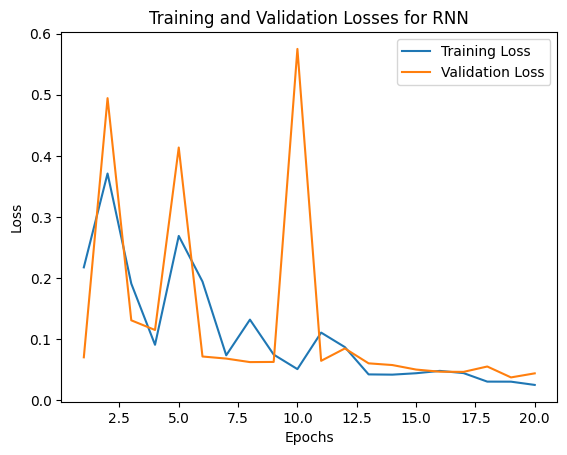

In [ ]:

print("RNN Start Trianing: \n")
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(rnn_model, rnn_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("RNN",rnn_train_losses, rnn_val_losses, epochs)


In [ ]:

print("LSTM Start Trianing: \n")
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(lstm_model, lstm_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("LSTM",lstm_train_losses, lstm_val_losses, epochs)

##CNN

In [ ]:
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding

from string import punctuation
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


In [ ]:
X_train

13148                [丰县, 大沙河, 红富士, 苹果, 🍎, 上, 元]
4705                           [巧儿, 黄金梨, 果乐, 农庄]
7806                      [云南, 果然, 小, 杨, 香蕉, 代办]
7385                                 [便宜, 香蕉, 找]
7029                                    [甜瓜, 香蕉]
                          ...                   
2464               [晚秋, 黄梨光果, 大量, 上市, 需, 老板, 联系]
6621                      [包, 质量, 香蕉, 问题, 全部, 吃]
12569      [苹果, 大量, 上市, 客商, 愿意, 前, 采购, 诚信, 保质保量]
670                      [贡梨,  , 纸袋, 山西, 高原, 水果]
10885    [陕西, 咸阳, 永寿, 红富士, 口感, 好现, 摘, 现卖, 需, 联系]
Name: description_token, Length: 11174, dtype: object

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

vocab_size = 5000
# Apply one_hot to each string within the Series
X_train = X_train.apply(lambda x: [one_hot(d, vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~') for d in x])
X_test = X_test.apply(lambda x: [one_hot(d, vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~') for d in x])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 5000
max_length = 100

# Flatten the list of lists after one-hot encoding
X_train = X_train.apply(lambda x: [item for sublist in x for item in sublist])
X_test = X_test.apply(lambda x: [item for sublist in x for item in sublist])

# Now pad the sequences
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:

model = Sequential([
    Embedding(vocab_size, 8, input_length=max_length),
   Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
  Dense(10, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
350/350 [==============================] - 7s 16ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/20
350/350 [==============================] - 6s 16ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/20
350/350 [==============================] - 5s 15ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/20
350/350 [==============================] - 5s 15ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/20
350/350 [==============================] - 8s 22ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/20
350/350 [==============================] - 6s 18ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/20
350/350 [==============================] - 5s 15ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 8/20
350/350 [==============================] - 6

In [ ]:
loss, accuracy = model.evaluate(X_train,y_train)
print('Testing Accuracy is {} '.format(accuracy*100))

350/350 [==============================] - 2s 7ms/step - loss: nan - acc: 0.0000e+00
Testing Accuracy is 0.0 


###old version

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
np.array(X_train_vect_avg).shape

(11174, 100)

In [ ]:
y_train.shape

(11174,)

In [ ]:
# Reshape X_train_vect_avg into a 2D NumPy array
X_train_vect_avg = np.array(X_train_vect_avg)

# Check the shape to ensure it's a 2D array
print(X_train_vect_avg.shape)

history = model.fit(X_train_vect_avg, y_train, epochs=20,
                  validation_data=(X_test_vect_avg, y_test))

(11174, 100)
Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_7' (type Sequential).
    
    Input 0 of layer "conv1d_7" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 100)
    
    Call arguments received by layer 'sequential_7' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 100), dtype=float32)
      • training=True
      • mask=None


In [ ]:
history = model.fit(X_train_vect_avg, y_train, epochs=20,
                  validation_data=(X_test_vect_avg, y_test))

ValueError: Data cardinality is ambiguous:
  x sizes: 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100
  y sizes: 11174
Make sure all arrays contain the same number of samples.

In [ ]:
   model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),#, input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam', # Or any other optimizer
              loss='categorical_crossentropy', # Choose appropriate loss for your problem
              metrics=['accuracy']) # Add metrics to track

In [ ]:
history = model.fit(X_train_vect_avg, y_train, batch_size=96, epochs=15, validation_split = 0.2)

In [ ]:
y_pred_CNN = history.predict(X_test_vect_avg)

In [ ]:
print(classification_report(y_test,y_pred_CNN,labels=df['IN code'].unique()))

In [ ]:
#instantiate model
X_train = X_train.to_numpy()
X_test =X_test.to_numpy()
y_train =y_train.to_numpy().astype('float32')
y_test =y_test.to_numpy().astype('float32')
print(X_train.shape,y_train.shape)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(80,activation='relu', input_shape=(100,)))
model.add(layers.Dense(80,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',#(lr=0.001)
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(X_train.shape,y_train.shape)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#validation data training
model = models.Sequential()
model.add(layers.Dense(80,activation='relu', input_shape=(100,)))
model.add(layers.Dense(80,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


model.compile(optimizer='rmsprop',#(lr=0.001)
              loss='binary_crossentropy',
              metrics=['accuracy'])


list1 =[1000,5000,8000]
list2 = ['bo','yo','go']
list3 = ['b','y','g']

for i,d,l, in zip(list1,list2,list3):
  history = model.fit(X_train,y_train,epochs=50,batch_size=i,validation_split=0.3)
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  epochs = range(1,len(loss_values)+1)

  plt.plot(epochs, loss_values, d, label='Training loss')

  plt.plot(epochs,val_loss_values, l,label='Validation loss')

plt.legend()

plt.show()

In [ ]:
list1 =[12571,1]
list2 = [1,12571]
list3 = ['bo','yo']
list4 = ['b','y']
for v1,v2,v3,v4 in zip(list1,list2,list3,list4):
  history = model.fit(X_train,y_train,epochs=v1,batch_size=v2,validation_split=0.3)
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  epochs = range(1,len(loss_values)+1)

  plt.plot(epochs, loss_values, v3, label='Training loss')

  plt.plot(epochs,val_loss_values, v4,label='Validation loss')

plt.legend()

plt.show()

test set

In [ ]:
history = model.fit(X_train,y_train,epochs=100,batch_size=5000,validation_split=0.3)
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')

plt.plot(epochs,val_loss_values, 'r',label='Validation loss')

In [ ]:
results = model.evaluate(X_test,y_test)
print(results)

In [ ]:
history = model.fit(X_train,y_train,epochs=50,batch_size=5000)
results = model.evaluate(X_test,y_test)
print(results)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss'][:]
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(y == min(val_loss_values), 'b',label='Validation loss')
plt.plot(epochs,val_loss_values, 'b',label='Validation loss')

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
results = model.evaluate(X_test,y_test)
print(results)

save model

In [ ]:
#save model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
import numpy
import os

In [ ]:
model.save('/content/drive/My Drive/dense_layer')

In [ ]:
 keras.models.load_model('/content/drive/My Drive/dense_layer')

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")